Loaded 4 images for stitching.
------------------------------
Stitching image 2 (tajm2.jpg) onto panorama...
Match success: 991 good matches found.
Stitch 1 completed. New panorama size: (1518, 1762, 3)
Stitching image 3 (tajm3.jpg) onto panorama...
Match success: 732 good matches found.
Stitch 2 completed. New panorama size: (1518, 2328, 3)
Stitching image 4 (tajm4.jpg) onto panorama...
Match success: 773 good matches found.
Stitch 3 completed. New panorama size: (1518, 3189, 3)
------------------------------
Final panorama saved to: Output\taj_panorama.jpg


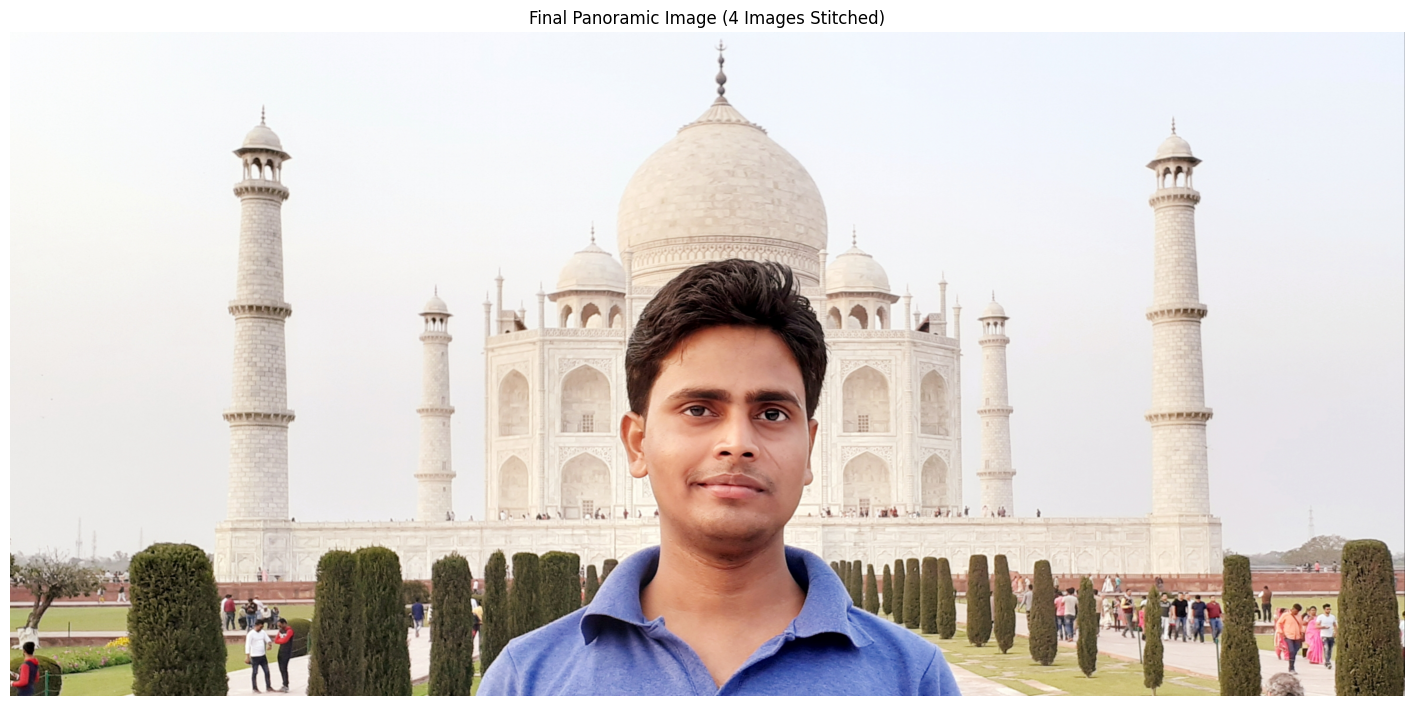

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- 1. SETUP AND FILE LOADING ---

# Define input/output paths
INPUT_DIR = 'Data'
OUTPUT_DIR = 'Output'
OUTPUT_FILENAME = 'taj_panorama.jpg'

# The 4 images you want to stitch in order (left to right)
image_files = ['tajm1.jpg', 'tajm2.jpg', 'tajm3.jpg', 'tajm4.jpg'] 
image_paths = [os.path.join(INPUT_DIR, f) for f in image_files]

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Read images
images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is None:
        print(f"Error: Could not load image {path}. Skipping.")
        continue
    # OpenCV loads images as BGR, convert to RGB for Matplotlib/consistent processing
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

if len(images) < 2:
    raise ValueError("Need at least two valid images to stitch. Check the 'Data' folder.")

print(f"Loaded {len(images)} images for stitching.")
print("-" * 30)


# --- 2. SIFT, MATCHING, AND HOMOGRAPHY (Core Logic - Definitions Unchanged) ---

def find_keypoints_and_descriptors(image):
    """Initializes SIFT detector and finds keypoints and descriptors."""
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_and_find_homography(kp1, des1, img1, kp2, des2, img2):
    """Matches descriptors and calculates the Homography matrix using RANSAC."""
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2) 

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H, mask, good_matches
    else:
        return None, None, None

def warp_images(img1, img2, H):
    """Warps img1 onto img2 using the calculated Homography matrix H and blends."""
    
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    img1_corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(img1_corners, H)
    
    all_corners = np.concatenate((transformed_corners, np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)), axis=0)
    
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    
    T = np.float32([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])
    H_new = T @ H 

    pano_width = xmax - xmin
    pano_height = ymax - ymin
    
    warped_img1 = cv2.warpPerspective(img1, H_new, (pano_width, pano_height))
    warped_img2 = cv2.warpPerspective(img2, T, (pano_width, pano_height))

    # --- Blending Logic ---
    result = warped_img2.copy()
    mask1 = warped_img1 > 0
    mask2 = warped_img2 > 0
    overlap = mask1 & mask2
    
    if np.any(overlap):
        # Using a more robust blending mask based on the presence of the images
        result[mask1 & ~mask2] = warped_img1[mask1 & ~mask2] # Add non-overlapping parts of img1
        
        # Simple cross-dissolve blend in the overlap region
        start_col = np.argmax(np.any(overlap, axis=(0, 2)))
        end_col = np.argmax(np.any(np.flip(overlap, axis=1), axis=(0, 2)))
        end_col = pano_width - end_col

        # Ensure start_col < end_col
        if start_col < end_col:
            for x in range(start_col, end_col):
                alpha = (x - start_col) / (end_col - start_col)
                result[:, x] = warped_img2[:, x] * (1 - alpha) + warped_img1[:, x] * alpha
        else:
             result[mask1] = warped_img1[mask1] # Fallback: img1 overwrites img2

    return result


# --- 3. EXECUTION FLOW: CHAIN STITCHING ---

# Initialize the panorama with the first image
if len(images) > 0:
    panorama = images[0]
else:
    raise ValueError("No images loaded.")

# Loop through the remaining images, stitching each one onto the growing panorama
for i in range(1, len(images)):
    img_current = images[i]
    print(f"Stitching image {i+1} ({image_files[i]}) onto panorama...")

    # 1. Find features for the CURRENT image and the current PANORAMA
    kp_pano, des_pano = find_keypoints_and_descriptors(panorama)
    kp_current, des_current = find_keypoints_and_descriptors(img_current)

    # 2. Match features and find Homography (H maps CURRENT image -> PANORAMA)
    # Note: We swap the order in the function call to match img1 (current) onto img2 (pano)
    H, mask, matches = match_and_find_homography(kp_current, des_current, img_current, kp_pano, des_pano, panorama)
    
    if H is not None:
        print(f"Match success: {len(matches)} good matches found.")
        # 3. Warp the CURRENT image onto the PANORAMA
        # We warp img_current (img1) onto the existing panorama (img2)
        panorama = warp_images(img_current, panorama, H)
        print(f"Stitch {i} completed. New panorama size: {panorama.shape}")
    else:
        print(f"Stitch FAILED for {image_files[i]}. Stopping sequence.")
        break


# --- 4. FINAL OUTPUT AND DISPLAY ---

if len(images) > 0 and H is not None:
    # Save the result (Convert back to BGR for OpenCV saving)
    pano_bgr = cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR)
    output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)
    cv2.imwrite(output_path, pano_bgr)
    print("-" * 30)
    print(f"Final panorama saved to: {output_path}")

    # Display the final image
    plt.figure(figsize=(18, 10))
    plt.imshow(panorama)
    plt.title(f'Final Panoramic Image ({len(images)} Images Stitched)')
    plt.axis('off')
    plt.show()

In [2]:
import os
print(os.listdir('Data'))

['tajm1.jpg', 'tajm2.jpg', 'tajm3.jpg', 'tajm4.jpg']


Loaded 4 images for stitching.
------------------------------
Stitch step 1: Matching tajm2.jpg onto Pano 0. Good matches: 974.
Stitch 1 completed. New panorama size: (1518, 1762, 3)
Stitch step 2: Matching tajm3.jpg onto Pano 1. Good matches: 708.
Stitch 2 completed. New panorama size: (1518, 2328, 3)
Stitch step 3: Matching tajm4.jpg onto Pano 2. Good matches: 783.
Stitch 3 completed. New panorama size: (1518, 3189, 3)


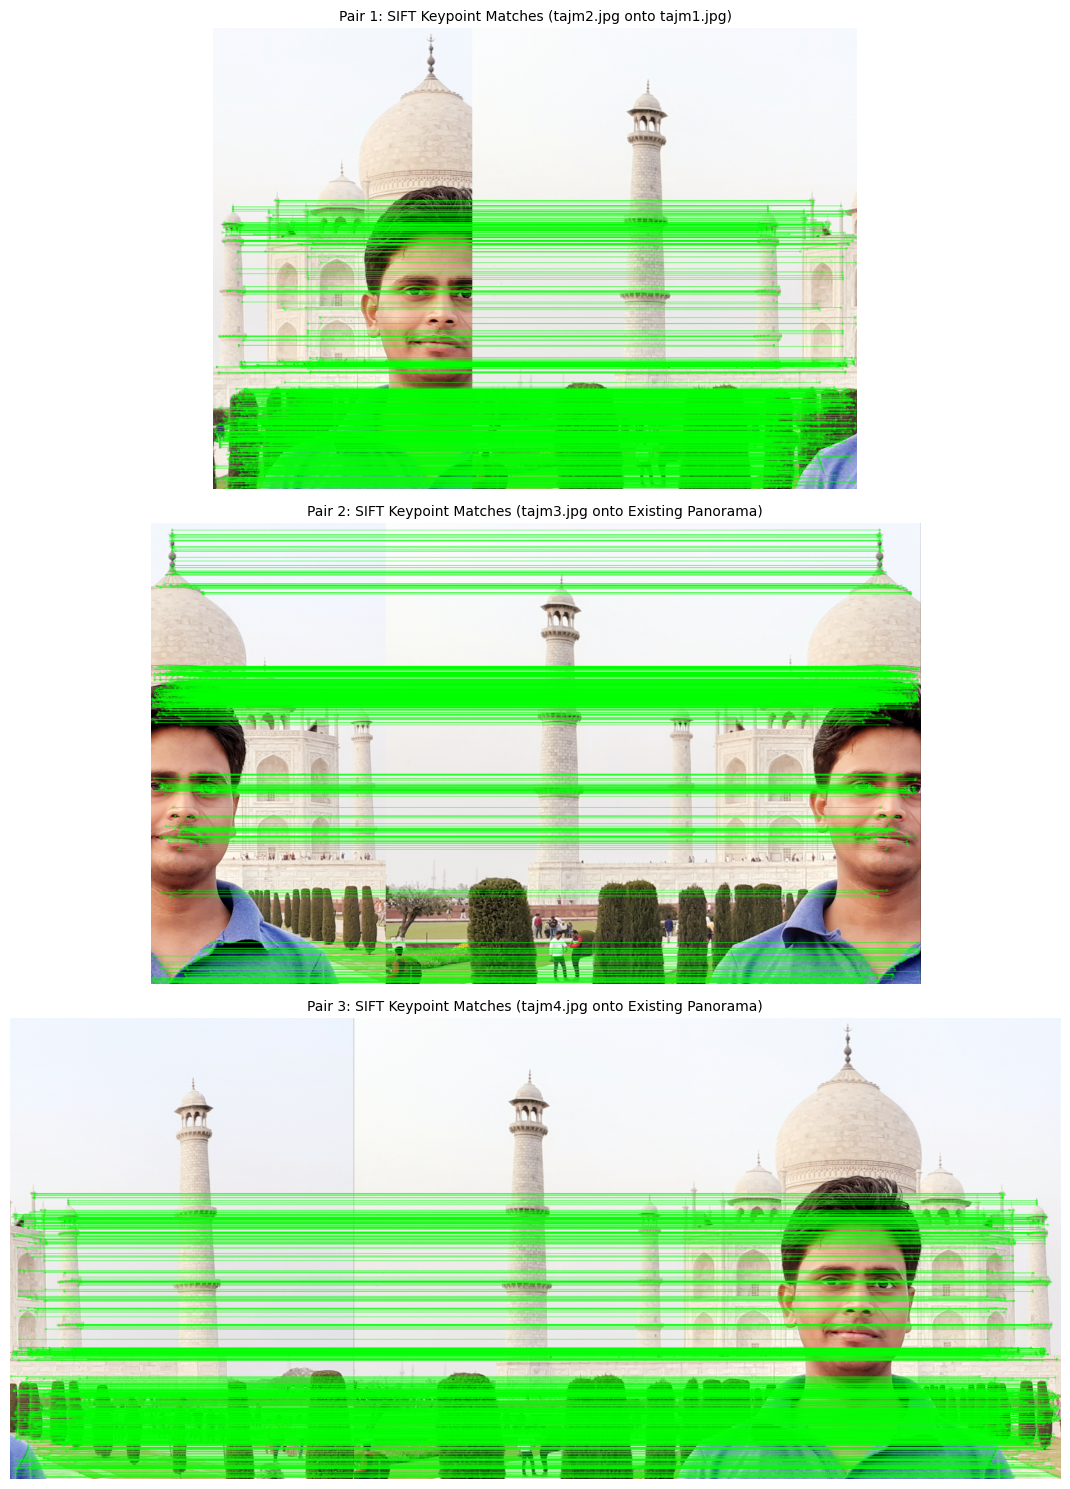

------------------------------
Final panorama saved to: Output\taj_panorama.jpg


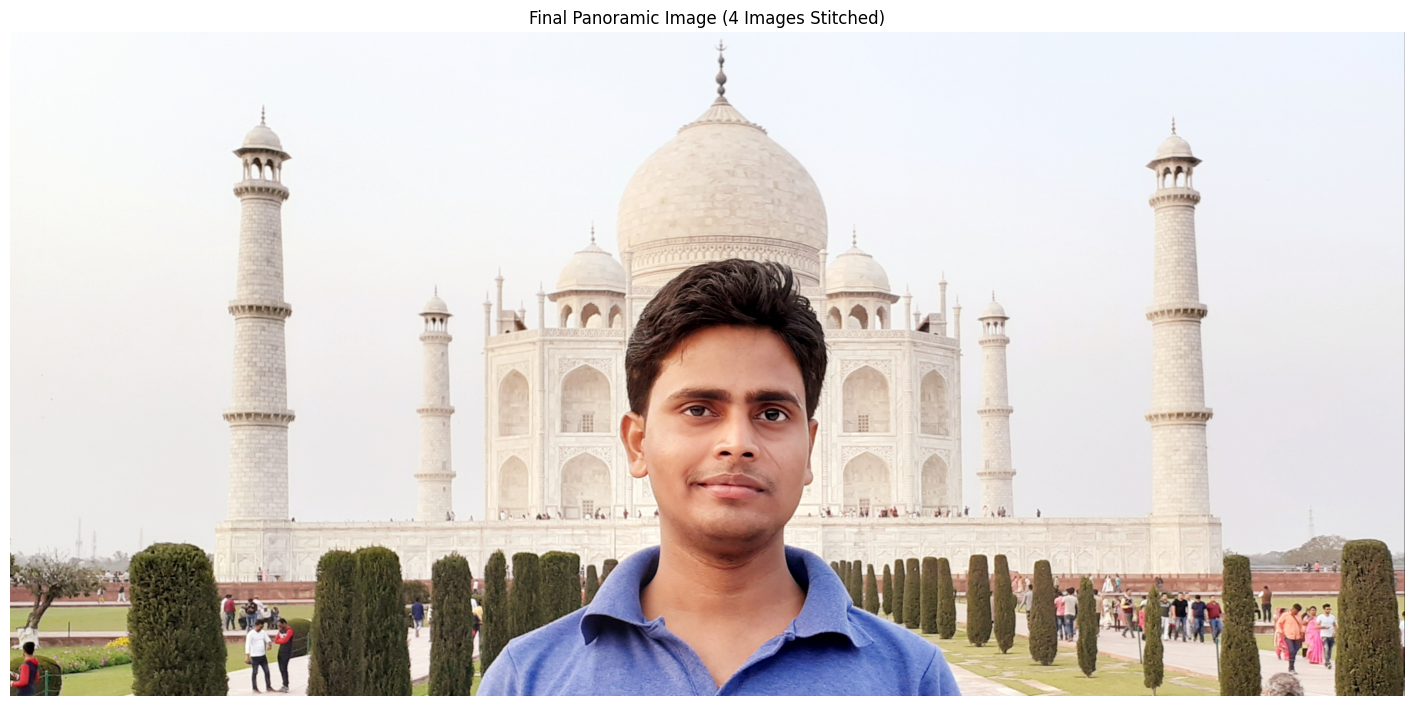

In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- 1. SETUP AND FILE LOADING ---

# Define input/output paths
INPUT_DIR = 'Data'
OUTPUT_DIR = 'Output'
OUTPUT_FILENAME = 'taj_panorama.jpg'

# The 4 images you want to stitch in order (left to right)
image_files = ['tajm1.jpg', 'tajm2.jpg', 'tajm3.jpg', 'tajm4.jpg'] 
image_paths = [os.path.join(INPUT_DIR, f) for f in image_files]

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Read images
images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is None:
        print(f"Error: Could not load image {path}. Skipping.")
        continue
    # Load images as BGR (OpenCV default) 
    images.append(img) 

if len(images) < 2:
    raise ValueError("Need at least two valid images to stitch. Check the 'Data' folder.")

print(f"Loaded {len(images)} images for stitching.")
print("-" * 30)


# --- 2. SIFT, MATCHING, AND HOMOGRAPHY (Core Logic - Definitions Unchanged) ---

def find_keypoints_and_descriptors(image):
    """Initializes SIFT detector and finds keypoints and descriptors."""
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_and_find_homography(kp1, des1, img1, kp2, des2, img2):
    """Matches descriptors and calculates the Homography matrix using RANSAC."""
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2) 

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H, mask, good_matches
    else:
        return None, None, None

def warp_images(img1, img2, H):
    """Warps img1 onto img2 using the calculated Homography matrix H and blends."""
    
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    img1_corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(img1_corners, H)
    
    all_corners = np.concatenate((transformed_corners, np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)), axis=0)
    
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    
    T = np.float32([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])
    H_new = T @ H 

    pano_width = xmax - xmin
    pano_height = ymax - ymin
    
    warped_img1 = cv2.warpPerspective(img1, H_new, (pano_width, pano_height))
    warped_img2 = cv2.warpPerspective(img2, T, (pano_width, pano_height))

    # --- Blending Logic ---
    result = warped_img2.copy()
    
    mask1 = np.any(warped_img1 > 0, axis=2) 
    mask2 = np.any(warped_img2 > 0, axis=2)
    
    overlap = mask1 & mask2
    
    # 1. Non-overlapping parts (img1 fills in the black space of img2)
    result[mask1 & ~mask2] = warped_img1[mask1 & ~mask2] 
    
    # 2. Overlap region: Simple cross-dissolve blend
    if np.any(overlap):
        cols = np.where(np.any(overlap, axis=0))[0]
        if cols.size > 0:
            start_col = cols[0]
            end_col = cols[-1]

            if start_col < end_col:
                for x in range(start_col, end_col + 1):
                    alpha = (x - start_col) / (end_col - start_col)
                    result[:, x] = warped_img2[:, x] * (1 - alpha) + warped_img1[:, x] * alpha
            else:
                 result[mask1] = warped_img1[mask1] 

    return result


# --- 3. EXECUTION FLOW: CHAIN STITCHING ---

# Initialize the panorama with the first image
if len(images) > 0:
    # Use the first image as the base (the "warped onto" target)
    panorama = images[0].copy() 
else:
    raise ValueError("No images loaded.")

# Loop through the remaining images, stitching each one onto the growing panorama
plt.figure(figsize=(15, 15)) # Create one main figure for all match plots
plot_counter = 1

for i in range(1, len(images)):
    # The current image to be stitched (the moving image)
    img_current = images[i]
    # The base image (the existing panorama)
    img_base = panorama 
    
    # Find features for the CURRENT image and the current PANORAMA
    kp_base, des_base = find_keypoints_and_descriptors(img_base)
    kp_current, des_current = find_keypoints_and_descriptors(img_current)

    # Match features and find Homography (H maps CURRENT image -> BASE PANORAMA)
    # H maps: kp_current (queryIdx) -> kp_base (trainIdx)
    H, mask, matches = match_and_find_homography(kp_current, des_current, img_current, kp_base, des_base, img_base)
    
    if H is not None:
        print(f"Stitch step {i}: Matching {image_files[i]} onto Pano {i-1}. Good matches: {len(matches)}.")
        
        # --- VISUALIZATION STEP (KEYPOINT IMAGE for the Current Pair) ---
        
        # Determine the name for the keypoint image title
        if i == 1:
            title_tag = f"{image_files[i]} onto {image_files[i-1]}"
        else:
            title_tag = f"{image_files[i]} onto Existing Panorama"

        # Draw matches (img_current and img_base)
        matches_mask = mask.ravel().tolist()
        keypoint_img = cv2.drawMatches(img_current, kp_current, img_base, kp_base, 
                                       matches, None, 
                                       matchColor=(0, 255, 0), # Green lines
                                       matchesMask=matches_mask, 
                                       flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        # Display the keypoint image using Matplotlib
        plt.subplot(len(images) - 1, 1, plot_counter) # Subplot for visualization
        plt.imshow(cv2.cvtColor(keypoint_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Pair {i}: SIFT Keypoint Matches ({title_tag})', fontsize=10)
        plt.axis('off')
        plot_counter += 1


        # 3. Warp the CURRENT image onto the PANORAMA (BASE image)
        # The result of the warp becomes the new, larger panorama base
        panorama = warp_images(img_current, img_base, H)
        print(f"Stitch {i} completed. New panorama size: {panorama.shape}")
    else:
        print(f"Stitch FAILED for {image_files[i]}. Stopping sequence.")
        break

plt.tight_layout()
plt.show()

# --- 4. FINAL OUTPUT AND DISPLAY ---

if H is not None:
    # Save the result
    output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)
    cv2.imwrite(output_path, panorama) 
    print("-" * 30)
    print(f"Final panorama saved to: {output_path}")

    # Display the final image (Convert to RGB for Matplotlib display)
    final_panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(18, 10))
    plt.imshow(final_panorama_rgb)
    plt.title(f'Final Panoramic Image ({len(images)} Images Stitched)')
    plt.axis('off')
    plt.show()